In [9]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")

SystemError: SystemError: opening file "/home/bart/Desktop/Masterproef /Julia codes/Notebooks with initial implementations/julia_functions.jl": No such file or directory

__The idea:__

Extract from a Tenet.TensorNetwork a high level representation in terms of a Graphs.jl structure which we can reason on to find the nodes and stuff

__Ingriedients of such a mapping:__
- A dictionary which maps the tensors to the vertices?
- A dictionary which maps a tensor index to a edge? 
- How the fuck can an AI reason on this data-structure???? Hahaha

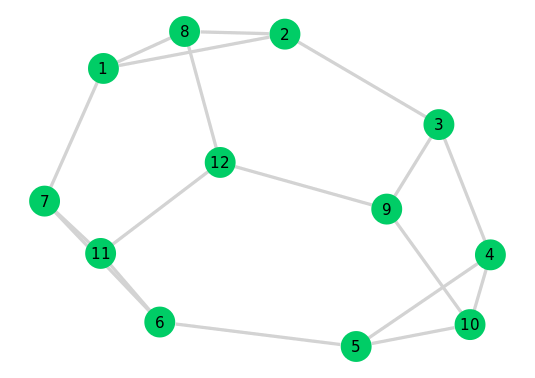

SimpleGraph{Int64}

In [10]:
function fill_with_random(G, dims, visualisation = false)

    """
    Function which takes in a Graphs.jl graph-structure (G) and which generates a Tenet.TensorNetwork based on the connectivity of the network.
    First of all each node is filled with a random tensor, the dims arguement shows the size of each index. Other more complex fill options can be added later down the line
    """
    
    nvertices = nv(G) # number of vertices
    nedges = ne(G)    # number of edges

    nodes = [node for node in vertices(G)]
    edgesgraph = [edge for edge in edges(G)]
    edges_labels = [Symbol(edge) for edge in 1:nedges]
    edges_map = Dict(zip(edgesgraph, edges_labels))

    if visualisation == true
        display(gplot(G, nodelabel=nodes, nodefillc=colorant"springgreen3", layout=spring_layout))
    end


    tensors = []
    # Generating the tensors inside of the network
    for source in vertices(G)
        inds = Tuple([edges_map[edge] for edge in edges(G) if source in([src(edge), dst(edge)])])
        size_generation_tuple = Tuple([dims for i in 1:length(inds)])
        push!(tensors, Tensor(rand(size_generation_tuple...), inds))
        
    end

    TN = TensorNetwork(tensors)
    return TN

end


dimension = 3
G = Graphs.smallgraph(:frucht)
tn1 = fill_with_random(G, dimension, true)
typeof(G)



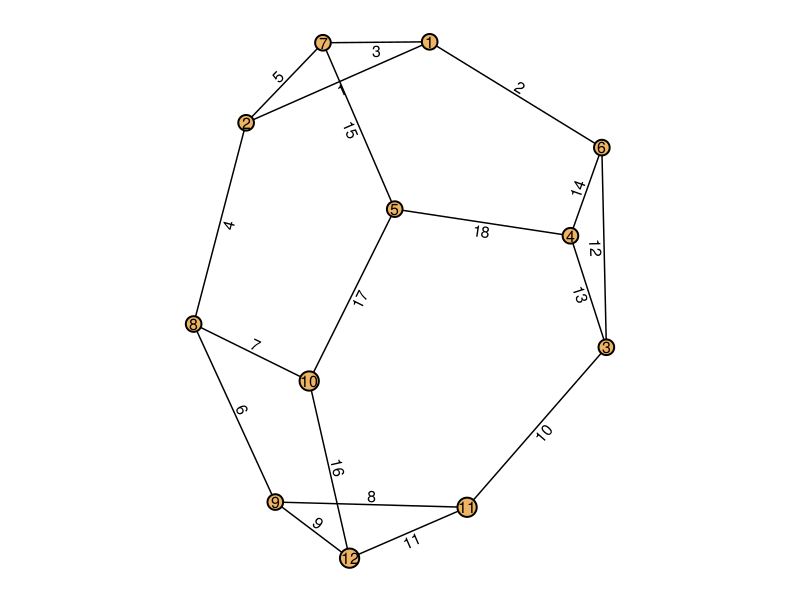

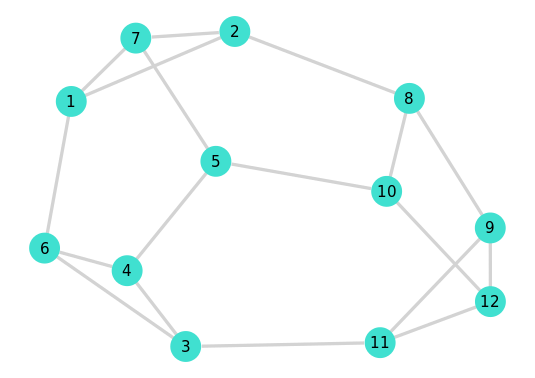

Amount of extracted vertices = 12
Amount of extracted edges = 18
Dict{Int64, Tensor}(5 => [0.07161673605976693 0.12536343692762242 0.7945202122561716; 0.17894786972880972 0.4445478603693853 0.7829707683701711; 0.4083980408631408 0.7951206478614151 0.6505190782564756;;; 0.9319938580122609 0.43998092026985913 0.28668449672818885; 0.8862152264203333 0.5859783307535164 0.4916373480938552; 0.15098434515665826 0.8209997328887794 0.23074846504341373;;; 0.3170618596588972 0.748772064390423 0.011815710002388013; 0.9109176159935238 0.7675171020947461 0.9513213272790229; 0.1624521171170653 0.6518396355843981 0.17196461017190967], 12 => [0.2053731924941018 0.3780664818031628 0.9577654585117767; 0.5904003362284282 0.18453571043288586 0.6623107857326617; 0.18165938514795243 0.18734715344702846 0.04557126246534593;;; 0.8018980909149888 0.5111298498390021 0.16407665604420207; 0.045763245180778456 0.7290812290910792 0.5357359015616333; 0.17253841847367268 0.634346944159566 0.5959229342621605;;; 0.15629

12×12 SparseArrays.SparseMatrixCSC{Int64, Int64} with 36 stored entries:
 ⋅  1  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅
 1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅

12×12 SparseArrays.SparseMatrixCSC{Int64, Int64} with 48 stored entries:
  3  -1   ⋅   ⋅   ⋅  -1  -1   ⋅   ⋅   ⋅   ⋅   ⋅
 -1   3   ⋅   ⋅   ⋅   ⋅  -1  -1   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   3  -1   ⋅  -1   ⋅   ⋅   ⋅   ⋅  -1   ⋅
  ⋅   ⋅  -1   3  -1  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅  -1   3   ⋅  -1   ⋅   ⋅  -1   ⋅   ⋅
 -1   ⋅  -1  -1   ⋅   3   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 -1  -1   ⋅   ⋅  -1   ⋅   3   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅  -1   ⋅   ⋅   ⋅   ⋅   ⋅   3  -1  -1   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   3   ⋅  -1  -1
  ⋅   ⋅   ⋅   ⋅  -1   ⋅   ⋅  -1   ⋅   3   ⋅  -1
  ⋅   ⋅  -1   ⋅   ⋅   ⋅   ⋅   ⋅  -1   ⋅   3  -1
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1  -1  -1   3

6235.000000000004
Dict{Any, Any}([Symbol("1")] => Edge 1 => 2, [Symbol("15")] => Edge 5 => 7, [Symbol("16")] => Edge 10 => 12, [Symbol("14")] => Edge 4 => 6, [Symbol("6")] => Edge 8 => 9, [Symbol("3")] => Edge 1 => 7, [Symbol("17")] => Edge 5 => 10, [Symbol("9")] => Edge 9 => 12, [Symbol("5")] => Edge 2 => 7, [Symbol("13")] => Edge 3 => 4, [Symbol("18")] => Edge 4 => 5, [Symbol("8")] => Edge 9 => 11, [Symbol("10")] => Edge 3 => 11, [Symbol("2")] => Edge 1 => 6, [Symbol("12")] => Edge 3 => 6, [Symbol("7")] => Edge 8 => 10, [Symbol("11")] => Edge 11 => 12, [Symbol("4")] => Edge 2 => 8)
156764.58545759448156764.58545759448


In [11]:
# numbering doesn't fit yet

function extract_graph_representation(TN, printing=false)

    """
    Function which takes in a TensorNetwork from Tenet.jl, this network only has one edge between two tensors (grouped indices) and no self loops.
    Based on the connectivity inside of the TensorNetwork a simple graph structure is generated.
    For this mapping a dictionary which has vertex labels as keys and corresponding tensors as values is generated.
    For this mapping a dictionary which has the corresponding edge as keys and as values the corresponding tensors indices.
    """

    n_vertices = length(tensors(TN))
    n_edges =  [[inds(tensor)...] for tensor in tensors(TN)]
    to_set = []
    for group in n_edges
        for element in group
            push!(to_set, element)
        end
    end
    n_edges = length(Set(to_set))
    
    if printing == true
        println("Amount of extracted vertices = ", n_vertices, "\nAmount of extracted edges = ", n_edges)
    end

    list_of_edges = collect((Set(to_set)))
    tensor_vertex_map = Dict{Int, Tenet.Tensor}()  # Specify the type of the keys and values
    for (i, tensor) in enumerate(tensors(TN))
        tensor_vertex_map[Int(i)] = tensor
    end
    println(tensor_vertex_map)

    g = SimpleGraph(n_vertices)
    nodes = [node for node in vertices(g)]

    # the connectivty inside of the tensor network should be mapped onto the connectivty of the SimpleGraph
    index_edge_map = Dict{}()
    pairs = collect(combinations([node for node in vertices(g)], 2))
    println(pairs)
    for possible_connection in pairs
        v1 = possible_connection[1]
        v2 = possible_connection[2]
        T_v1 = tensor_vertex_map[v1]
        T_v2 = tensor_vertex_map[v2]
        # connectivity measure
        index_intersection =  intersect(inds(T_v1), inds(T_v2))
        if length(index_intersection) == 1
            add_edge!(g, v1, v2)
            edge = [edge for edge in edges(g) if [src(edge), dst(edge)] == possible_connection][1]
            index_edge_map[index_intersection] = edge
        end
    end
    display(gplot(g, nodelabel=[node for node in vertices(g)]))
    println(index_edge_map)

    return g, tensor_vertex_map, index_edge_map

end

display(Makie.plot(tn1, labels=true, ilabels=[string(number) for number in 1:length(tensors(tn1))]))

graph, tensordict, edgesdict = extract_graph_representation(tn1, true)
adj_matrix = adjacency_matrix(graph)
laplacian = laplacian_matrix(graph)
vals  = eigvals(Matrix{Float64}(laplacian))
println(vals)
n_spanning = 1/12*prod([vals[i] for i in 2:12])
println("number of spanning trees = ", n_spanning)
display(adj_matrix)
display(laplacian)
println(edgesdict)

function graph_to_tensornetwork(graph_structure, tensors_dict, edges_dict)

    """
    Function which takes in a SimpleGraph from Graphs.jl, this network only has one edge between two tensors (grouped indices) and no self loops.
    Based on the connectivity inside of the SimpleGraph a corresponding tensor_network structure is generated.
    For this mapping a dictionary is used which has vertex labels as keys and corresponding tensors as values.
    For this mapping a dictionary is used which has the corresponding edge as keys and as values the corresponding tensors indices.
    """
    tensors = values(tensors_dict)
    TN = TensorNetwork(tensors)
    return TN

end


new_tn = graph_to_tensornetwork(graph, tensordict, edgesdict)
contracted1 = Tenet.contract(tn1)
contracted2 = Tenet.contract(new_tn)
println(contracted1[1] , contracted2[1])

In [16]:
# Get the cycle basis of the graph, which represents all simple cycles
# Playing around in graphs.jl
cycles = cycle_basis(graph)
num_cycles = length(cycles)

println("Number of simple cycles:", num_cycles)
println("Cycles:", (cycles))



println(extract_edges_from_cycle(cycles[2]))

  

Number of simple cycles:7
Cycles:[[9, 11, 12], [4, 3, 11, 12, 10, 5], [4, 6, 3], [7, 1, 6, 3, 11, 12, 10, 5], [7, 2, 1], [8, 2, 1, 6, 3, 11, 12, 10], [8, 9, 12, 10]]
[(4, 3), (3, 11), (11, 12), (12, 10), (10, 5), (5, 4)]
